# Explore data 
1. Determine effect of temperature on number of bike rides 
2. Controlling for any relevant seasonality

In [2]:
import pandas
READ_PATH = '/Users/calvinperumalla/cbs_data/data_100000_pts.csv'
df = pandas.read_csv(READ_PATH)

In [3]:
df.columns

Index(['Unnamed: 0', 'trip_id', 'year', 'month', 'week', 'day', 'hour',
       'usertype', 'gender', 'starttime', 'stoptime', 'tripduration',
       'temperature', 'events', 'from_station_id', 'from_station_name',
       'latitude_start', 'longitude_start', 'dpcapacity_start',
       'to_station_id', 'to_station_name', 'latitude_end', 'longitude_end',
       'dpcapacity_end'],
      dtype='object')

<BarContainer object of 3 artists>

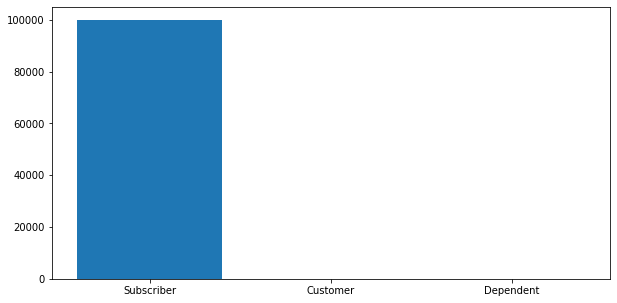

In [53]:
from collections import Counter
from matplotlib import pyplot as plt
x, y = zip(*Counter(df['usertype']).items())
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x, y)

## hour vs number of trips

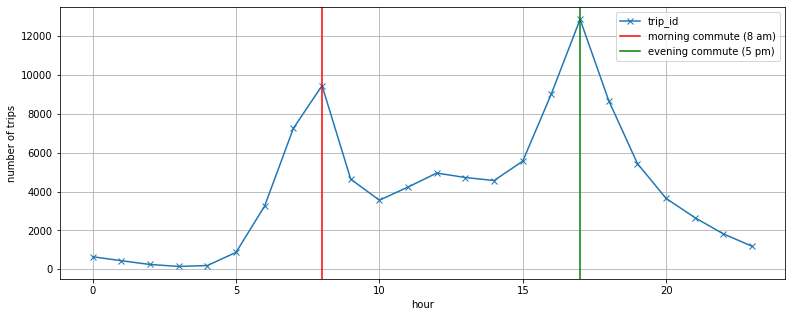

In [56]:
hour_df = df.groupby('hour').aggregate({'trip_id': pandas.Series.nunique})
f, ax = plt.subplots(figsize=(13, 5))
hour_df.plot(ax=ax, marker='x')
plt.ylabel('number of trips')
plt.axvline(8, label='morning commute (8 am)', color='r')
plt.axvline(17, label='evening commute (5 pm)', color='g')
plt.legend()
plt.grid()
plt.show()

Two local maxima show that the large number of trips in the data occur around 8 am and 5 pm. These trips may have been taken by commuters to and from work. 

Data majorly contains subscribers. 
Subscribers pay $99 a year and get unlimited rides under 45 minutes. These would be commuters to work mostly

In [48]:
df_strp = df[['temperature', 'trip_id', 'starttime', 'stoptime', 'tripduration', 'events']]
df_strp['date'] = pandas.to_datetime(df_strp['starttime']).dt.date

/Users/calvinperumalla/cbs_challenge/cbs_challenge/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Effect of month on trips
month vs number of trips

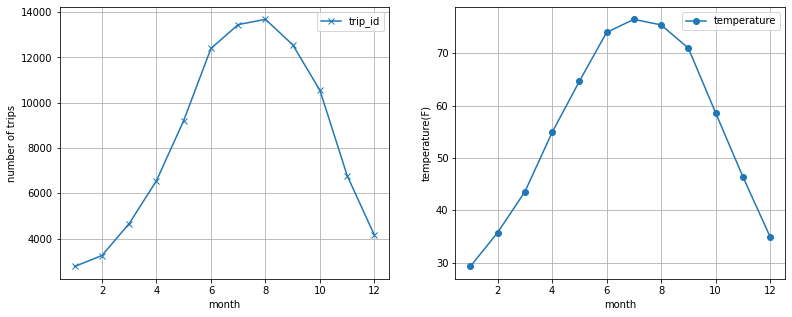

In [44]:
month_df = df.groupby('month').aggregate({'trip_id': pandas.Series.nunique})
f, ax = plt.subplots(1,2, figsize=(13, 5))
month_df.plot(ax=ax[0], marker='x')
ax[0].set_ylabel('number of trips')
ax[0].legend()
ax[0].grid()

month_temperature_df = df.groupby('month').aggregate({'temperature': pandas.Series.mean})
month_temperature_df.plot(ax=ax[1], marker='o')
ax[1].set_ylabel('temperature(F)')
plt.legend()
plt.grid()
plt.show()

- Most popular seasons to use the bike sharing is Summer and Fall, spring. June - September are peak months
- average temperature varies similarly with month 

## Effect of temperature on trip
bucket temperature into 5 degree buckets and count the number of trips taken when temperature was in that bucket

In [49]:
bucketize = lambda x: int(x/5) * 5
df_strp['temp_bkt'] = df_strp['temperature'].apply(bucketize)
tmp_grp = df_strp.groupby('temp_bkt').agg(num_trips=pandas.NamedAgg(column='trip_id', aggfunc='nunique'))

/Users/calvinperumalla/cbs_challenge/cbs_challenge/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


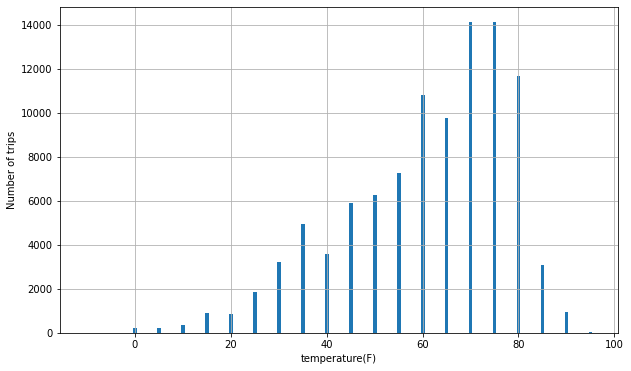

In [52]:
sorted_tmp = tmp_grp
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(sorted_tmp.index, sorted_tmp['num_trips'])
ax.set_xlabel('temperature(F)')
ax.set_ylabel('Number of trips')
ax.grid()

We see a positive correlation between temperature and number of trips, when temperature is less than ~80F and a steep drop off when it gets too hot (>80F) 

## Effect of temperature on trip length

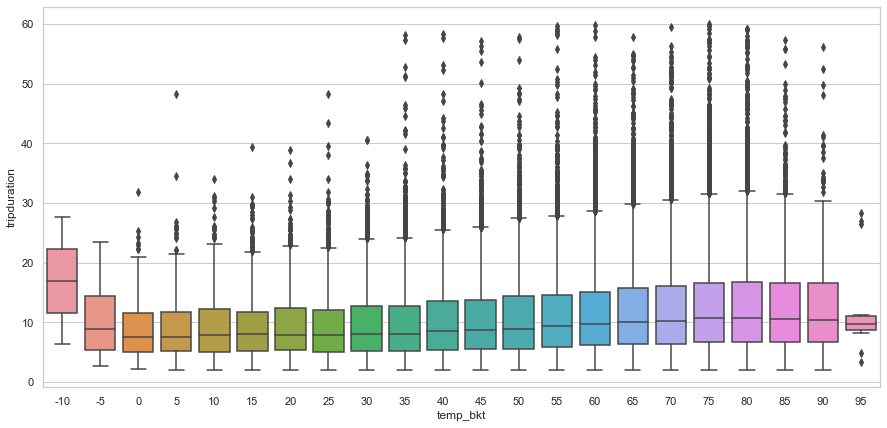

In [78]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(x='temp_bkt', y='tripduration', data=df_strp, ax=ax)

Fail to observe a substantial visual correlation between temperature and trip duration. However, 
We can observe more variance in the trip duration is it gets warmer

## Effect of events on trip length/#trips

In [61]:
set(df_strp['events'])

{'clear', 'cloudy', 'not clear', 'rain or snow', 'tstorms', 'unknown'}

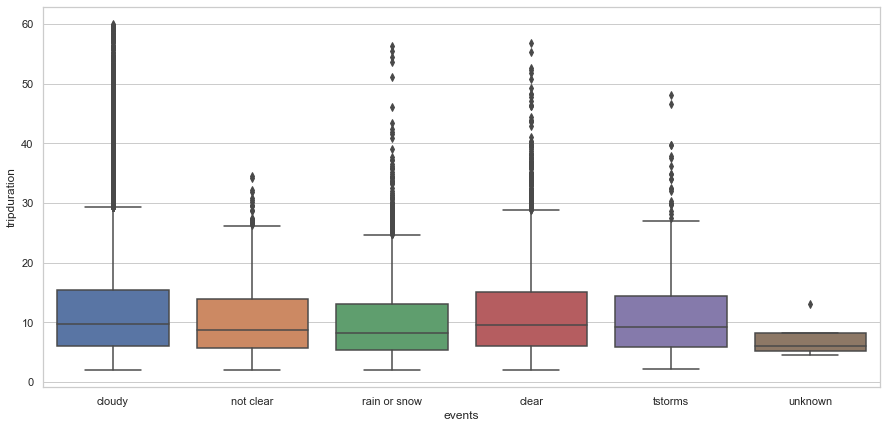

In [62]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(x='events', y='tripduration', data=df_strp, ax=ax)

 outliers less than 2.5% of the data (significant portion)

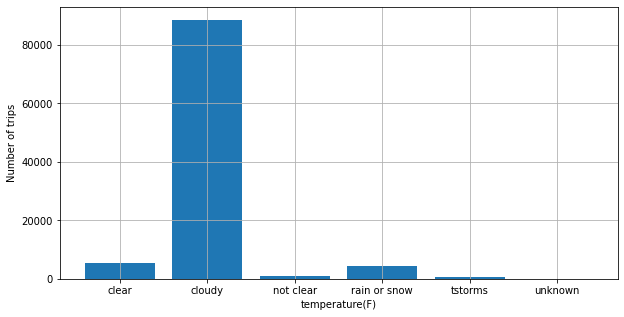

In [58]:
event_grp = df_strp.groupby('events').agg(num_trips=pandas.NamedAgg(column='trip_id', aggfunc='nunique'))
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(event_grp.index, event_grp['num_trips'])
ax.set_xlabel('temperature(F)')
ax.set_ylabel('Number of trips')
ax.grid()

Accoding to https://www.currentresults.com/Weather-Extremes/US/cloudiest-cities.php Chicago is one of the cloudiest cities in the US so the above plot makes sense.

### so far
Observations :
1. Data has a high proporation of subscribers (of which a high proportion are suspected to be commuters)
2. There is a strong relationship between temperature and number of trips. (positive between 0-80F and negative when greater than 80F)
3. Trip length does not seem to be affected by temerature. However, there seems to be a larger variance in trip length as it gets warmer
4. Most trips happen when it is cloudy. This could be just because Chicago is a cloudy city and whenever a trip is taken it is likely that it is cloudy (Chi is cloudy 270+ days /year)

Inferences
1. Extreme temperatures, snow, thunder storms affect number of trips negatively (as is intuitive): Understandable as people may not opt to bike on days when whether is inclement: Hot weather makes one sweat and commuters may not want to show up to work sweaty. It maybe inconvenient to bike in the snow due to sidewalks being slippery etc. And definitely people are not going biking during a thunder storm. 
2. Even though there are fewer trips during cold weather, the trip lengths are not too affected. Apart from the fact that the variance of the trip lengths increases. This could be because there tend to be more non-commuters bike rides it is warm.


## Day of the week vs number of trips

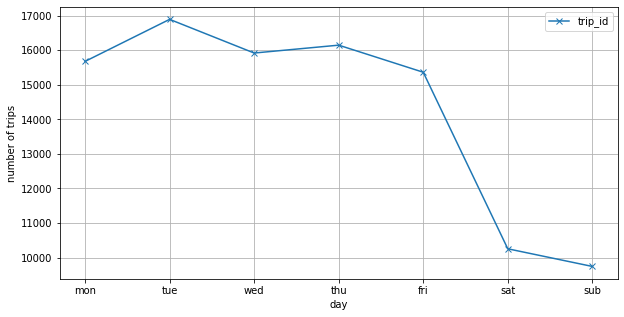

In [66]:
day_df = df.groupby('day').aggregate({'trip_id': pandas.Series.nunique})
f, ax = plt.subplots(figsize=(10, 5))
day_df.plot(ax=ax, marker='x')
plt.ylabel('number of trips')
plt.xticks([0,1,2,3,4,5,6], ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sub'])
plt.legend()
plt.grid()
plt.show()

## Effects of temperature on weekend

In [93]:
df['temp_bkt'] = df['temperature'].apply(bucketize)
df_weekend = df[(df['day']==5) | (df['day']==6)]
df_weekday = df[(df['day']!=5) | (df['day']!=6)]

(array([   0., 1703., 2669., 2689., 2295., 1918., 1634., 1445., 1205.,
        1071.,  816.,  666.,  612.,  387.,  274.,  173.,  100.,   84.,
          70.,   41.,   25.,   24.,   22.,   18.,   12.,   12.,    9.,
           5.,    8.,    8.,    0.,    0.,    0.,    0.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68]),
 <a list of 34 Patch objects>)

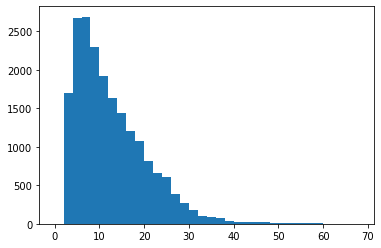

In [89]:
bins = list(range(0, 70, 2))
plt.hist(df_weekend['tripduration'], bins=bins)

(array([    0.,  9467., 15216., 14768., 12727., 10146.,  8266.,  6799.,
         5359.,  4436.,  3501.,  2824.,  2229.,  1469.,   929.,   560.,
          317.,   241.,   185.,   145.,    80.,    75.,    56.,    49.,
           38.,    29.,    27.,    19.,    24.,    19.,     0.,     0.,
            0.,     0.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68]),
 <a list of 34 Patch objects>)

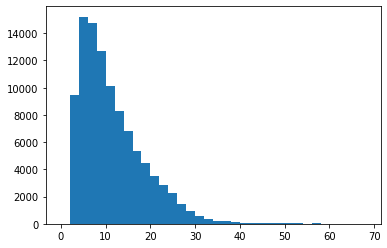

In [95]:
plt.hist(df_weekday['tripduration'], bins=bins)

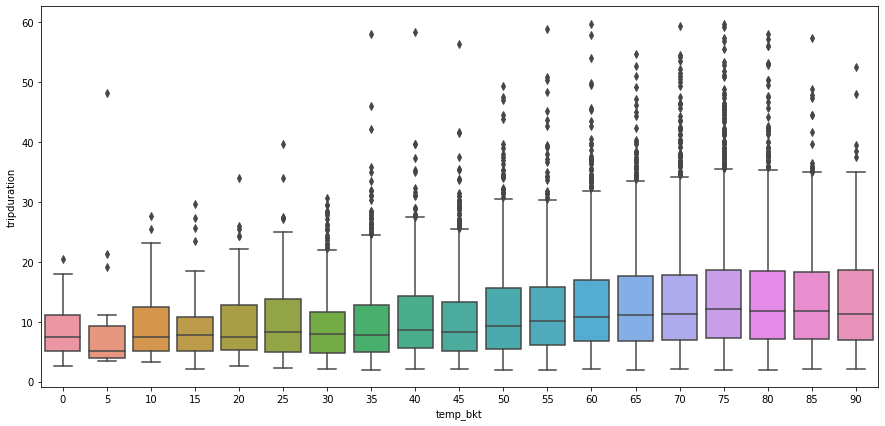

In [96]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(x='temp_bkt', y='tripduration', data=df_weekend, ax=ax)
#ax.scatter(df_weekend['temp_bkt'], df_weekend['tripduration'])

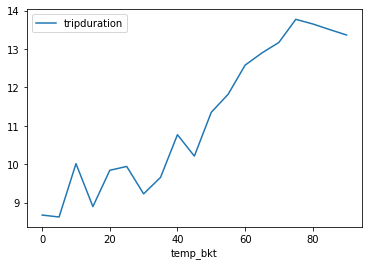

In [100]:
weekend_grp = df_weekend.groupby('temp_bkt').aggregate({'tripduration': pandas.Series.mean})
weekend_grp.plot()